# Text Generation

Here I'm using [Shakespeare plays](https://www.kaggle.com/kingburrito666/shakespeare-plays) by [LiamLarsen](https://www.kaggle.com/kingburrito666) to create a deep learning model which will be able to `generate text` using some input text.

**While doing all of this we will go through:**
- `Preprocessing` text data
- Building multilayer `Bidirectional RNN` model
- Saving `wording embeddings` learned by the learning algorithm

In [1]:
import io
import re
import json
import string
import unicodedata
from random import randint

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [2]:
!pip install contractions
!pip install tensorflow-addons

     |████████████████████████████████| 260 kB 1.2 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from tensorflow_addons.metrics import F1Score

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


## ✈️ Getting data

Actual  word of text file is `4583798`

In [5]:
def load_data(size_to_read=100_000):
    filename = '/kaggle/input/shakespeare-plays/alllines.txt'
    with open(filename, 'r') as f:
        data = f.read(size_to_read)
    return data


data = load_data(size_to_read=500_000)
data[:100]

'"ACT I"\n"SCENE I. London. The palace."\n"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMO'

## 🍭 Data preparation

Splitting our text data into `corpus` which in turn will be our `training samples`.

In [6]:
corpus = data.lower().split('\n')
print(corpus[:10])

['"act i"', '"scene i. london. the palace."', '"enter king henry, lord john of lancaster, the earl of westmoreland, sir walter blunt, and others"', '"so shaken as we are, so wan with care,"', '"find we a time for frighted peace to pant,"', '"and breathe short-winded accents of new broils"', '"to be commenced in strands afar remote."', '"no more the thirsty entrance of this soil"', '"shall daub her lips with her own children\'s blood,"', '"nor more shall trenching war channel her fields,"']


![](https://media.giphy.com/media/3o6gbbt9uYNcOtJ29y/giphy.gif)

In [7]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [8]:
for idx, sentence in enumerate(corpus):
    corpus[idx] = expand_contractions(sentence)
corpus[:5]

['"act i"',
 '"scene i. london. the palace."',
 '"enter king henry, lord john of lancaster, the earl of westmoreland, sir walter blunt, and others"',
 '"so shaken as we are, so wan with care,"',
 '"find we a time for frighted peace to pant,"']

In [9]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)


print(rm_punc_from_word('#cool!'))

cool


In [10]:
# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)


print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

Frankly my dear I dont give a damn


In [11]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space


print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [12]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)


rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [13]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [14]:
for idx, sentence in enumerate(corpus):
    corpus[idx] = clean_text(sentence)
corpus[:10]

['act',
 'scene london palace',
 'enter king henry lord john lancaster earl westmoreland sir walter blunt others',
 'shaken wan care',
 'find time frighted peace pant',
 'breathe shortwinded accents new broils',
 'commenced strands afar rthemote',
 'thirsty entrance soil',
 'shall daub lips childrens blood',
 'shall trenching war channel fields']

Removing sentences whose length is `1`.

In [15]:
print(f'Corpus size before: {len(corpus)}')
corpus = [sentence for sentence in corpus if len(sentence.split(' ')) > 1]
print(f'Corpus size now: {len(corpus)}')
corpus[:10]

Corpus size before: 11561
Corpus size now: 11037


['scene london palace',
 'enter king henry lord john lancaster earl westmoreland sir walter blunt others',
 'shaken wan care',
 'find time frighted peace pant',
 'breathe shortwinded accents new broils',
 'commenced strands afar rthemote',
 'thirsty entrance soil',
 'shall daub lips childrens blood',
 'shall trenching war channel fields',
 'bruise flowerets armed hoofs']

**🕶 Data visulaization**

![](https://media.giphy.com/media/TEcW5rhdWYZsdQLHKW/giphy.gif)

In [16]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)

In [17]:
# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords

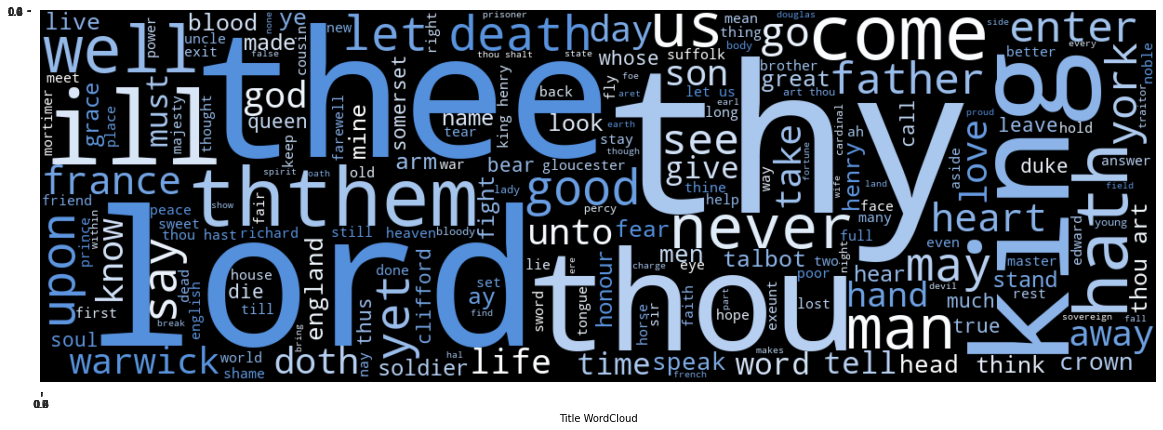

In [18]:
# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(
        stopwords=wc_stopwords, width=1200, height=400, random_state=0
    ).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(
            wc.recolor(color_func=color_func, random_state=0),
            interpolation="bilinear"
        )
        plt.xlabel('Title WordCloud')


plot_wordcloud(' '.join(corpus), wc_blue_color_func)

**Preparing data for neural network**

In [19]:
print(f"Vocab size: {len(set(' '.join(corpus).split(' ')))}")
oov_token = '<UNK>'

Vocab size: 8201


In [20]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(corpus)

word_index = tokenizer.word_index

total_words = len(word_index) + 1

'''
 Adding 1 to total_words to avoid below error
 
 IndexError                                Traceback (most recent call last)
    <ipython-input-136-16f89b53d516> in <module>
    ----> 1 y = tf.keras.utils.to_categorical(labels, num_classes=total_words)
          2 print(y[1])

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/np_utils.py in to_categorical(y, num_classes, dtype)
         76   n = y.shape[0]
         77   categorical = np.zeros((n, num_classes), dtype=dtype)
    ---> 78   categorical[np.arange(n), y] = 1
         79   output_shape = input_shape + (num_classes,)
         80   categorical = np.reshape(categorical, output_shape)

    IndexError: index 3049 is out of bounds for axis 1 with size 3049
    
 This is because of reserving padding (i.e. index zero).
 
 Stackoverflow post for more into: https://stackoverflow.com/questions/53525994/how-to-find-num-words-or-vocabulary-size-of-keras-tokenizer-when-one-is-not-as
'''

print(total_words)

8203


In [21]:
# Converting the text to sequence using the tokenizer
def get_input_sequences(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
        tokens_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(tokens_list)):
            n_gram_sequence = tokens_list[:i + 1]
            input_sequences.append(n_gram_sequence)

    return input_sequences


input_sequences = get_input_sequences(corpus, tokenizer)
print(input_sequences[:5])

[[70, 138], [70, 138, 398], [9, 7], [9, 7, 20], [9, 7, 20, 5]]


In [22]:
# getting the max len of among all sequences
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)

23


In [23]:
# padding the input sequence
padded_input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(padded_input_sequences[1])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  70 138 398]


Padding from starting since we are going to `predict the last word`.

In [24]:
# shuffling the data
np.random.shuffle(padded_input_sequences)

In [25]:
def map_sequence_to_text(x, y, index_word):
    text = ''
    for index in x:
        text += index_word[index] + ' '
    text += f'[{index_word[y]}]'
    return text

In [26]:
# Removing the input and output texts
x = padded_input_sequences[:, :-1]
labels = padded_input_sequences[:, -1]

print(x[17])
print(labels[17])

def map_sequence_to_text(x, y, index_word):
    text = ''
    for index in x:
        if index == 0:
            # index 0 == padded char
            continue
        text += index_word[index] + ' '
    text += f'[{index_word[y]}]'
    return text
map_sequence_to_text(x[17], labels[17], tokenizer.index_word)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1036]
3249


'spoke [deservings]'

In [27]:
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print(y[1])

[0. 0. 0. ... 0. 0. 0.]


## 👩‍🔬 Modelling

![](https://media.giphy.com/media/YS57N6teaevJASvcMA/giphy.gif)

In [28]:
lstm_units = 512
embedding_dim = 512
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'
num_epochs = 30

metrics = [
    'accuracy',
    AUC(curve='ROC', multi_label=True, name='auc_roc'),
    F1Score(num_classes=total_words, average='weighted')
]

In [29]:
class CustomCallback(Callback):
    def on_epoch_start(self, epoch, logs=None):
        print()
        
    def on_epoch_end(self, epoch, logs=None):
        loss = logs['loss']
        accuracy = logs['accuracy']
        f1_score = logs['f1_score']
        auc_roc = logs['auc_roc']

        info = {
            'loss': round(loss, 5),
            'accuracy': round(accuracy, 4),
            'auc_roc': round(auc_roc, 4),
            'f1_score': round(f1_score, 4),
        }

        print(f'\n{json.dumps(info, indent=2)}')


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    CustomCallback()
]

In [30]:
def build_model(
    total_words,
    max_sequence_len,
    lstm_units=lstm_units,
    embedding_dim=embedding_dim,
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
):
    model = Sequential([
        Embedding(total_words, embedding_dim, input_length=max_sequence_len - 1, trainable=True),
        Bidirectional(LSTM(lstm_units)),
        Dense(total_words, activation='softmax')
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


model = build_model(total_words, max_sequence_len, lstm_units, embedding_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 512)           4199936   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dense (Dense)                (None, 8203)              8408075   
Total params: 16,806,411
Trainable params: 16,806,411
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(x, y, epochs=num_epochs, callbacks=callbacks, verbose=1)

Epoch 1/30
1103/1103 [==============================] - ETA: 0s - loss: 7.9677 - accuracy: 0.0207 - auc_roc: 0.4370 - f1_score: 0.0047
{
  "loss": 7.96768,
  "accuracy": 0.0207,
  "auc_roc": 0.437,
  "f1_score": 0.0047
}
1103/1103 [==============================] - 62s 56ms/step - loss: 7.9677 - accuracy: 0.0207 - auc_roc: 0.4370 - f1_score: 0.0047
Epoch 2/30
1103/1103 [==============================] - ETA: 0s - loss: 7.2647 - accuracy: 0.0411 - auc_roc: 0.4409 - f1_score: 0.0150
{
  "loss": 7.26467,
  "accuracy": 0.0411,
  "auc_roc": 0.4409,
  "f1_score": 0.015
}
1103/1103 [==============================] - 63s 57ms/step - loss: 7.2647 - accuracy: 0.0411 - auc_roc: 0.4409 - f1_score: 0.0150
Epoch 3/30
1103/1103 [==============================] - ETA: 0s - loss: 6.3478 - accuracy: 0.0708 - auc_roc: 0.4569 - f1_score: 0.0383
{
  "loss": 6.34777,
  "accuracy": 0.0708,
  "auc_roc": 0.4569,
  "f1_score": 0.0383
}
1103/1103 [==============================] - 62s 56ms/step - loss: 6.3478 - 

**Plotting model's performance**

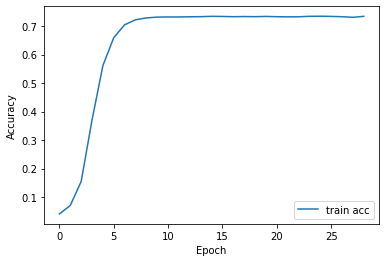

In [32]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

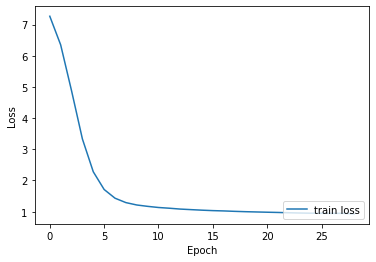

In [33]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [34]:
# Saving embedding vectors and words to visualize embeddings using `Tensorflow Projector`.
# Getting weights of our embedding layer
embedding_layer = model.layers[0]
embedding_layer_weigths = embedding_layer.get_weights()[0]
print(embedding_layer_weigths.shape)

# Reversing the `word_index`
word_index = tokenizer.word_index
reverse_word_index = {value: key for key, value in word_index.items()}

# Writing vectors and their meta data which when entered to Tensorflow Project,
# it will display our Word Embedding
out_vectors = io.open('vecs.tsv', 'w', encoding='utf-8')
out_metadata = io.open('meta.tsv', 'w', encoding='utf-8')
# Skipping over the first word in vocabulary which is '<OOV>' (if set oov_token parameter set then)
for word_num in range(1, total_words):
    words = reverse_word_index[word_num]
    embeddings = embedding_layer_weigths[word_num]
    out_metadata.write(words + '\n')
    out_vectors.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_vectors.close()
out_metadata.close()

(8203, 512)


The first value of the above output is the `vocab_size(total_words)` and second value is the `embedding_dim`.

## 🔮 Predictions

In [35]:
def predict_next(model, text, tokenizer, max_sequence_len, num_of_words=10):
    # predict next num_of_words for text
    for _ in range(num_of_words):
        input_sequences = tokenizer.texts_to_sequences([text])[0]
        padded_input_sequences = pad_sequences(
            [input_sequences], maxlen=max_sequence_len - 1, padding='pre'
        )
        predicted = model.predict_classes(padded_input_sequences, verbose=0)
        output_word = ''

        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        text += ' ' + output_word

    return text

In [36]:
seed_text = 'The sky is'
print(predict_next(model, seed_text, tokenizer, max_sequence_len, num_of_words=4))

The sky is us get spirits betwixt


In [37]:
seed_text = 'Everything is fair in love and'
print(predict_next(model, seed_text, tokenizer, max_sequence_len, num_of_words=10))

Everything is fair in love and follow mine wears equal mine ere tinker tomb legs ever


In [38]:
seed_text = 'My life'
print(predict_next(model, seed_text, tokenizer, max_sequence_len, num_of_words=15))

My life holy oath still think sirrah gone gone go farewell farewell shall h ththem call ththem


In [39]:
seed_text = 'You are a type of guy that'
print(predict_next(model, seed_text, tokenizer, max_sequence_len, num_of_words=20))

You are a type of guy that cheeks withal withal highway mortimer let ththem dead eyes tears heart duchy fight though much tears tears babes tears h


In [40]:
seed_text = 'FROM off a hill whose concave womb reworded A plaintful'
print(predict_next(model, seed_text, tokenizer, max_sequence_len, num_of_words=5))

FROM off a hill whose concave womb reworded A plaintful withal withal resolution part ththem


## 🎁 Saving the model

In [41]:
model.save('model')

---

If this kernel helped you then don't forget to 👍 `like` and give your 🎙 `feedback`.

![](https://media.giphy.com/media/oveqQA2LxpwYg/giphy.gif)

---